In [1]:
from google.colab import drive
drive.mount('/content/drive')

#fileDownloaded = drive.CreateFile({'id':'14nPUbtZzmzCBcJx9yPyBIf7KL7BSrV6e'})
#fileDownloaded.GetContentFile('train.csv')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

raw_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")


#feature creation
raw_df['Date'] = pd.to_datetime(raw_df['Ob'])

raw_df['month'] = raw_df['Date'].dt.month
raw_df['day'] = raw_df['Date'].dt.day
raw_df['hour'] = raw_df['Date'].dt.hour
raw_df['year'] = raw_df['Date'].dt.year

In [3]:
y = raw_df.target
X = raw_df.drop(['target','Ob','Date'], axis=1)
X
test_df

,Station,Ob,value,measure,R_flag,I_flag,Z_flag,B_flag
0,AURO,3/25/2021 10:37,24.500,temp_wxt,2,-1,2,0
1,AURO,7/11/2021 13:22,31.500,temp_wxt,2,-1,0,1
2,AURO,7/11/2021 13:23,31.500,temp_wxt,2,-1,0,1
3,AURO,7/11/2021 13:24,31.500,temp_wxt,2,-1,0,1
4,AURO,7/11/2021 13:25,31.600,temp_wxt,2,-1,0,1
...,...,...,...,...,...,...,...,...
1856101,WINE,4/21/2021 23:56,-7.890,blackglobetemp,4,-1,-1,-1
1856102,WINE,4/21/2021 23:57,-7.890,blackglobetemp,4,-1,-1,-1
1856103,WINE,4/21/2021 23:58,-7.927,blackglobetemp,4,-1,-1,-1
1856104,WINE,4/21/2021 23:59,-7.927,blackglobetemp,4,-1,-1,-1


Counter({False: 6358102, True: 235172})
dict_items([(False, 6358102), (True, 235172)])


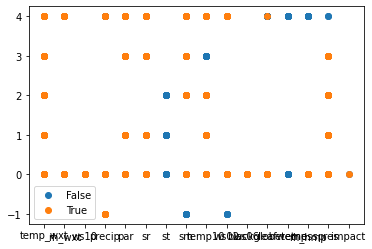

In [4]:

# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from matplotlib import pyplot
from numpy import where

counter = Counter(y)
print(counter)
# scatter plot - value, measure, target
print(counter.items())

pyplot.scatter
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter( X.iloc[row_ix, 2], X.iloc[row_ix, 3], label=str(label))
pyplot.legend()
pyplot.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


False    6358102
True      235172
Name: target, dtype: int64

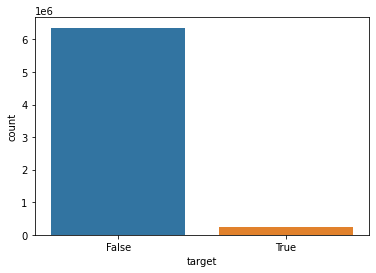

In [5]:
import seaborn as sns

sns.countplot(raw_df['target'])
y.value_counts()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X.drop(['Station','measure'], axis=1), y, train_size=0.8, random_state=123)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


False    5086539
True     5086539
Name: target, dtype: int64


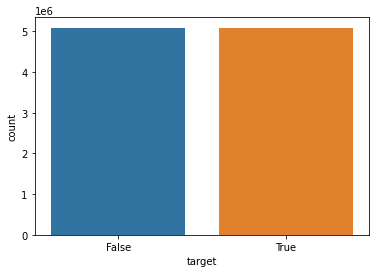

In [7]:
from imblearn.over_sampling import SMOTE
import seaborn as sns

sm = SMOTE(sampling_strategy='minority', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

sns.countplot(oversampled_train['target'])
print(oversampled_train['target'].value_counts())


In [8]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(oversampled_trainX, oversampled_trainY)

pred_train = classifier.predict(X_train)
pred_test = classifier.predict(X_test)


In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print('Accuracy for training data')
print(accuracy_score(y_train, pred_train))
print('Accuracy for test data')
print(accuracy_score(y_test, pred_test))
print()
print('Confusion matrix for test data')
print(confusion_matrix(y_test, pred_test))
print()
print('Classification report for test data')
print(classification_report(y_test, pred_test))


Accuracy for training data
0.9993112298727169
Accuracy for test data
0.996179440414665

Confusion matrix for test data
[[1267787    3776]
 [   1262   45830]]

Classification report for test data
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1271563
        True       0.92      0.97      0.95     47092

    accuracy                           1.00   1318655
   macro avg       0.96      0.99      0.97   1318655
weighted avg       1.00      1.00      1.00   1318655



Logistic: f1=0.948 auc=0.988


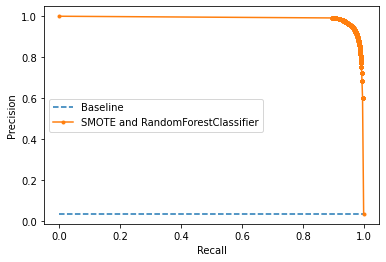

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# predict probabilities
lr_probs = classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, pred_test), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline')
pyplot.plot(lr_recall, lr_precision, marker='.', label='SMOTE and RandomForestClassifier')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# Test feature creation
test_df['Date'] = pd.to_datetime(test_df['Ob'])

test_df['month'] = test_df['Date'].dt.month
test_df['day'] = test_df['Date'].dt.day
test_df['hour'] = test_df['Date'].dt.hour
test_df['year'] = test_df['Date'].dt.year

In [ ]:
test_data = test_df.drop(['Ob','Date','Station','measure'], axis=1)
actual_test = classifier.predict_proba(test_data)

In [ ]:
pd.DataFrame(actual_test[:,1], columns=['target']).to_csv('/content/drive/MyDrive/predictions.csv', index=False)